In [38]:
from utils import align_face, face_morph
from PIL import Image
import projector
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt	
from scipy.interpolate import CubicSpline

In [10]:
anna_path = 'images/anna.jpg'
filip_path = 'images/filip.jpg'
emma_path = 'images/emma.jpg'
oliver_path = 'images/oliver.jpg'
image_paths = [anna_path, filip_path, emma_path, oliver_path]

In [24]:
# create a list of all the image paths
aligned_faces = []	
for path in image_paths:
	path = Image.open(path)
	aligned_faces.append(align_face(path))


In [25]:
# convert every image to numpy array
aligned_faces = [np.array(face) for face in aligned_faces]

# convert every image to a tensor
aligned_faces = [torch.tensor(face) for face in aligned_faces]

# put the last dimension first
aligned_faces = [face.permute(2, 0, 1) for face in aligned_faces]

# check the shape of all the faces
for face in aligned_faces:
	print(face.shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [27]:
# Set device
if(torch.backends.mps.is_available()): # True
    print("MPS is available")
    device = torch.device("mps")


# Load the generator model from the pickle file
with open('ffhq_res256.pkl', 'rb') as f:
	G = pickle.load(f)['G_ema'].to(device) 
      


MPS is available


In [29]:
# project the images to the latent space
latent = []
for face in aligned_faces:
	latent.append(projector.project(G, target=face, num_steps=4, device=device, verbose=True))

print(latent)

Computing W midpoint and stddev using 10000 samples...
step    1/4: dist 0.59 loss 14851.56
step    2/4: dist 0.53 loss 26918.26
step    3/4: dist 0.45 loss 21175.92
step    4/4: dist 0.40 loss 10549.35
Computing W midpoint and stddev using 10000 samples...
step    1/4: dist 0.57 loss 38048.98
step    2/4: dist 0.52 loss 8384.10
step    3/4: dist 0.39 loss 9071.14
step    4/4: dist 0.36 loss 5717.98
Computing W midpoint and stddev using 10000 samples...
step    1/4: dist 0.68 loss 19224.47
step    2/4: dist 0.50 loss 7795.70
step    3/4: dist 0.41 loss 7100.14
step    4/4: dist 0.36 loss 5213.81
Computing W midpoint and stddev using 10000 samples...
step    1/4: dist 0.55 loss 20688.61
step    2/4: dist 0.53 loss 13955.25
step    3/4: dist 0.48 loss 12169.16
step    4/4: dist 0.43 loss 4989.09
[tensor([[[ 0.3648,  0.0354,  0.0826,  ...,  0.2412,  0.4028, -0.0132],
         [ 0.3648,  0.0354,  0.0826,  ...,  0.2412,  0.4028, -0.0132],
         [ 0.3648,  0.0354,  0.0826,  ...,  0.2412, 

In [68]:
squeezed = []

for projection in latent:
	squeezed.append(projection[-1].unsqueeze(0))

print(len(squeezed))

4


In [69]:
# bring the latent tensors to the cpu
squeezed = [projection.cpu().detach().numpy() for projection in squeezed]

# Define corresponding x-positions for each tensor (you can customize these)
x = np.array([0, 1, 2, 3])

# The interpolation points (e.g., multiple points between tensors)
# This creates 100 points between x=0 and x=3 to visualize the process
x_interp_steps = np.linspace(x[0], x[-1], 10)

# Stack the tensors along a new dimension to create a higher-dimensional array
tensor_array = np.stack(squeezed, axis=0)  # Shape (4, 2, 2)

# Initialize an array to store all interpolated steps
# It will be (100, 2, 2) for this example (100 points, each tensor is 2x2)
interpolated_tensors = np.empty((len(x_interp_steps),) + squeezed[0].shape)

# Store spline coefficients for each tensor element
coefficients = {}

# Apply cubic interpolation element-wise across tensors
for i in range(tensor_array.shape[1]):  # Loop over first dimension (rows)
    for j in range(tensor_array.shape[2]):  # Loop over second dimension (columns)
        # Extract the 1D array of each element across all tensors
        y = tensor_array[:, i, j]  # Shape (4,) for each element in (i, j) position
        
        # Perform cubic spline interpolation for that element
        cs = CubicSpline(x, y, bc_type='natural')  # bc_type='natural' ensures natural spline
        
        # Store the spline coefficients for this element (i, j)
        coefficients[(i, j)] = cs.c  # Coefficients are stored in .c
        
        # Evaluate the interpolation at multiple points
        interpolated_tensors[:, i, j] = cs(x_interp_steps)

# Output the interpolated tensors at the steps
print("Interpolated tensors at each step between the tensors:")
print(interpolated_tensors)

# Output the coefficients for each element (i, j)
print("\nCubic spline coefficients for each element (i, j):")
for (i, j), coeff in coefficients.items():
    print(f"Element ({i}, {j}):")
    print(coeff)

# If you want to visualize or extract the tensor at a specific step
# For example, the tensor at step 50 (halfway through interpolation):
step = 5
print(f"\nInterpolated Tensor at step {step} (x_interp = {x_interp_steps[step]}):")
print(interpolated_tensors[step].shape)








Interpolated tensors at each step between the tensors:
[[[[ 0.31150779  0.08429828  0.34535456 ...  0.36040056  0.70182794
     0.12663549]
   [ 0.31150779  0.08429828  0.34535456 ...  0.36040056  0.70182794
     0.12663549]
   [ 0.31150779  0.08429828  0.34535456 ...  0.36040056  0.70182794
     0.12663549]
   ...
   [ 0.31150779  0.08429828  0.34535456 ...  0.36040056  0.70182794
     0.12663549]
   [ 0.31150779  0.08429828  0.34535456 ...  0.36040056  0.70182794
     0.12663549]
   [ 0.31150779  0.08429828  0.34535456 ...  0.36040056  0.70182794
     0.12663549]]]


 [[[ 0.27380935  0.05278813  0.35118775 ...  0.244052    0.47633618
    -0.0035328 ]
   [ 0.27380935  0.05278813  0.35118775 ...  0.244052    0.47633618
    -0.0035328 ]
   [ 0.27380935  0.05278813  0.35118775 ...  0.244052    0.47633618
    -0.0035328 ]
   ...
   [ 0.27380935  0.05278813  0.35118775 ...  0.244052    0.47633618
    -0.0035328 ]
   [ 0.27380935  0.05278813  0.35118775 ...  0.244052    0.47633618
    -0.00

In [78]:

# remove second dimension
interpolated_tensors = interpolated_tensors.squeeze(1)
# convert every tensor in the list to a tensor
interpolated_tensors = [torch.tensor(tensor, dtype=torch.float32) for tensor in interpolated_tensors]

# put all the tensors in a new tensor
interpolated_tensors = torch.stack(interpolated_tensors)

# put all the tensors on the gpu
interpolated_tensors = interpolated_tensors.to(device)

print(interpolated_tensors[0].shape)




torch.Size([14, 512])


<ipython-input-78-76a95f1b8aa9>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interpolated_tensors = [torch.tensor(tensor, dtype=torch.float32) for tensor in interpolated_tensors]


In [73]:

img = G.synthesis(interpolated_tensors, noise_mode='const', force_fp32=True)


In [77]:
print(len(img))

256


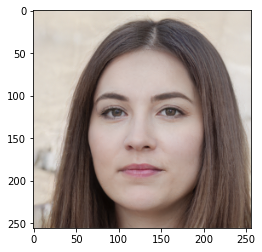

In [74]:
img = (img + 1) * (255/2)
img = img.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
plt.imshow(img)

TypeError: Invalid shape (3,) for image data

<Figure size 432x288 with 0 Axes>

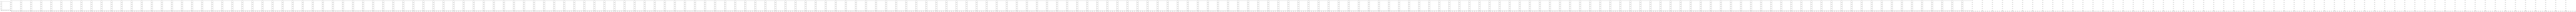

In [79]:
#clear the plot
plt.clf()

#insert face1array image in the begining and face2array image in the end
# interpolated_images = np.insert(img, 0, face1_array, axis=0)
# interpolated_images = np.insert(img, len(interpolated_images), face2_array, axis=0)

num_images = len(img)
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

if num_images == 1:
	axes = [axes]

for i, img in enumerate(img):
	axes[i].imshow(img)
	axes[i].axis('off')
	axes[i].set_frame_on(False)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()